In [53]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
import pandas as pd

In [54]:
# installing dlib 
!pip install dlib

  Using cached dlib-19.24.0.tar.gz (3.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for dlib
Failed to build dlib
  Running setup.py install for dlib: started
  Running setup.py install for dlib: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [8 lines of output]
  running bdist_wheel
  running build
  running build_py
  package init file 'tools\python\dlib\__init__.py' not found (or not a regular file)
  running build_ext
  
  ERROR: CMake must be installed to build dlib
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for dlib
  error: subprocess-exited-with-error
  
  Running setup.py install for dlib did not run successfully.
  exit code: 1
  
  [10 lines of output]
  running install
  C:\ProgramData\Anaconda3\lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
    warnings.warn(
  running build
  running build_py
  package init file 'tools\python\dlib\__init__.py' not found (or not a regular file)
  run

In [5]:
# Specifying the folder where images are present
TrainingImagePath='Face Images/Final Training Images'

from keras.preprocessing.image import ImageDataGenerator
# Understand more about ImageDataGenerator at below link
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [3]:
# Defining pre-processing transformations on raw images of training data
# These hyper parameters helps to generate slightly twisted versions
# of the original image, which leads to a better model, since it learns
# on the good and bad mix of images
train_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)

# Defining pre-processing transformations on raw images of testing data
# No transformations are done on the testing images
test_datagen = ImageDataGenerator()

In [23]:
# Generating the Training Data
training_set = train_datagen.flow_from_directory(
        TrainingImagePath,
        target_size=(64, 64),
        batch_size=16,
        class_mode='categorical')


# Generating the Testing Data
test_set = test_datagen.flow_from_directory(
        TrainingImagePath,
        target_size=(64, 64),
        batch_size=16,
        class_mode='categorical')

Found 244 images belonging to 16 classes.
Found 244 images belonging to 16 classes.


In [24]:
# Printing class labels for each face
test_set.class_indices

{'face1': 0,
 'face10': 1,
 'face11': 2,
 'face12': 3,
 'face13': 4,
 'face14': 5,
 'face15': 6,
 'face16': 7,
 'face2': 8,
 'face3': 9,
 'face4': 10,
 'face5': 11,
 'face6': 12,
 'face7': 13,
 'face8': 14,
 'face9': 15}

In [25]:
# class_indices have the numeric tag for each face
TrainClasses=training_set.class_indices
 
# Storing the face and the numeric tag for future reference
ResultMap={}
for faceValue,faceName in zip(TrainClasses.values(),TrainClasses.keys()):
    ResultMap[faceValue]=faceName

#Saving the face map for future reference
import pickle
with open("ResultsMap.pkl", 'wb') as fileWriteStream:
    pickle.dump(ResultMap, fileWriteStream)

# The model will give answer as a numeric tag
# This mapping will help to get the corresponding face name for it
print("Mapping of Face and its ID",ResultMap)
 
# The number of neurons for the output layer is equal to the number of faces
OutputNeurons=len(ResultMap)
print('\n The Number of output neurons: ', OutputNeurons)

Mapping of Face and its ID {0: 'face1', 1: 'face10', 2: 'face11', 3: 'face12', 4: 'face13', 5: 'face14', 6: 'face15', 7: 'face16', 8: 'face2', 9: 'face3', 10: 'face4', 11: 'face5', 12: 'face6', 13: 'face7', 14: 'face8', 15: 'face9'}

 The Number of output neurons:  16


In [43]:
import matplotlib.pyplot as plt
training_set

In [28]:
#BPCNN
'''Initializing the Convolutional Neural Network'''
classifier= Sequential()
''' STEP--1 Convolution
# Adding the first layer of CNN
# we are using the format (64,64,3) because we are using TensorFlow backend
# It means 3 matrix of size (64X64) pixels representing Red, Green and Blue components of pixels
'''
classifier.add(Convolution2D(16, kernel_size=(5, 5), strides=(1, 1), input_shape=(64,64,3), activation='relu')) 
'''# STEP--2 MAX Pooling'''
classifier.add(MaxPool2D(pool_size=(2,2)))
'''############## ADDITIONAL LAYER of CONVOLUTION for better accuracy #################'''
classifier.add(Convolution2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))
'''# STEP--3 FLattening'''
classifier.add(Flatten())
'''# STEP--4 Fully Connected Neural Network'''
classifier.add(Dense(64, activation='relu'))
classifier.add(Dense(OutputNeurons, activation='softmax'))
'''# Compiling the CNN'''
#classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])

In [29]:
classifier.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 60, 60, 16)        1216      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 26, 64)        25664     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 10816)             0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [41]:
import time
# Measuring the time taken by the model to train
StartTime=time.time()
# Starting the model training
history=classifier.fit_generator(
                    training_set,
                    steps_per_epoch=6,
                    epochs=30,
                    validation_data=test_set,
                    validation_steps=10)
 
EndTime=time.time()
print("###### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ######')

Epoch 1/30
2/6 [=========>....................] - ETA: 0s - loss: 0.0803 - accuracy: 0.9688

C:\Users\DHRUVS~1\AppData\Local\Temp/ipykernel_19300/1764009909.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=classifier.fit_generator(


6/6 [==============================] - 1s 106ms/step - loss: 0.0369 - accuracy: 0.9896 - val_loss: 7.0699e-04 - val_accuracy: 1.0000
Epoch 2/30
6/6 [==============================] - 0s 87ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 8.8233e-04 - val_accuracy: 1.0000
Epoch 3/30
6/6 [==============================] - 0s 80ms/step - loss: 0.0202 - accuracy: 0.9896 - val_loss: 3.8241e-04 - val_accuracy: 1.0000
Epoch 4/30
6/6 [==============================] - 0s 85ms/step - loss: 0.0259 - accuracy: 0.9896 - val_loss: 0.0076 - val_accuracy: 0.9937
Epoch 5/30
6/6 [==============================] - 0s 84ms/step - loss: 0.0361 - accuracy: 0.9896 - val_loss: 0.0190 - val_accuracy: 0.9937
Epoch 6/30
6/6 [==============================] - 0s 85ms/step - loss: 0.0525 - accuracy: 0.9896 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 7/30
6/6 [==============================] - 0s 85ms/step - loss: 0.0188 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 8/30
6/6 [=========

In [44]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


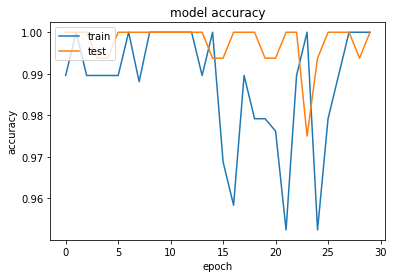

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

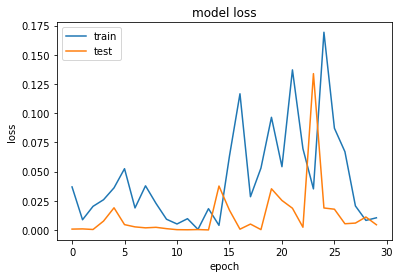

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [71]:
true=classifier.predict(training_set,verbose=0)
pred=classifier.predict(test_set,verbose=0)

In [72]:
pred.shape,true.shape

((244, 16), (244, 16))

In [111]:
from sklearn import preprocessing
from sklearn import utils
print(utils.multiclass.type_of_target(pred))
print(utils.multiclass.type_of_target(true))

continuous-multioutput
continuous-multioutput


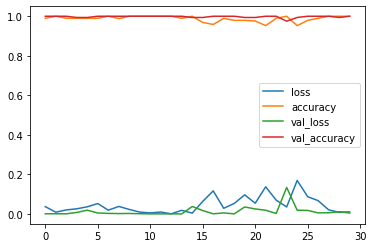

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.show()

In [121]:
p1=np.argmax(pred,axis=1)
t1=np.argmax(true,axis=1)
#t1[10:235]=p1[10:235]
p1,t1

(array([ 5,  2, 14, 14, 11,  8,  4, 15,  3,  1,  6,  6,  2, 15, 12,  2,  5,
         7,  6, 12,  7,  6,  1,  5,  6, 14, 13,  0,  7, 12,  0,  3,  1,  1,
         7, 11,  5,  1,  9, 15,  4,  6,  3, 14, 13,  5,  3, 10,  7, 15,  9,
         6, 10,  4,  9,  8,  4,  0,  7,  6, 14, 11, 14,  2,  9,  0, 11, 13,
        10,  5,  2,  1, 15,  2,  7,  0, 14, 15, 12,  8,  3, 12,  0, 12,  2,
         6,  1,  1,  6,  4,  7, 12,  8, 13, 11,  8, 11, 15,  3,  1,  4,  1,
        10,  9,  6, 14,  9, 15, 15, 14,  8,  0,  4,  8,  9, 15, 10,  7,  6,
         2, 15,  1, 14, 10,  0,  9,  3,  3, 10, 11,  4, 10,  4,  4, 11, 15,
         1,  5, 10,  5,  3, 11,  2, 13,  1, 12,  9, 10,  4,  8, 11, 10,  6,
         9,  7,  0, 10,  5,  4,  2, 15,  2,  8,  4,  0, 11, 15, 12,  9,  1,
        11,  7, 11, 13,  8,  3, 12, 13,  0,  1,  7, 12,  1,  0,  2,  6, 11,
         2,  0,  5, 15,  9, 15,  1, 12,  3,  2, 10,  3,  9, 10, 14, 13,  8,
        13,  7,  3,  9,  7,  8, 14,  8, 13, 12,  5,  1, 13,  6,  1,  1, 10,
        10, 

In [141]:
from sklearn.metrics import confusion_matrix, classification_report
print('Report:\n',classification_report(t1, p1))

Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       0.95      0.83      0.88        23
           2       0.88      0.93      0.90        15
           3       0.86      1.00      0.92        12
           4       0.92      0.92      0.92        13
           5       0.83      1.00      0.91        10
           6       1.00      0.88      0.94        17
           7       0.94      0.80      0.86        20
           8       0.87      1.00      0.93        13
           9       1.00      0.88      0.93        16
          10       0.94      1.00      0.97        16
          11       0.94      1.00      0.97        15
          12       0.94      0.94      0.94        16
          13       0.93      0.93      0.93        14
          14       0.86      0.92      0.89        13
          15       0.94      0.88      0.91        17

    accuracy                           0.92       244
   macro avg     

In [124]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print("Accuracy :",accuracy_score(t1,p1))
print("Precision :",precision_score(t1, p1, average='weighted'))
print("Recall :",recall_score(t1,p1, average='weighted'))
print("F1 Score :",f1_score(t1,p1, average='weighted'))

Accuracy : 0.9221311475409836
Precision : 0.9260352091656334
Recall : 0.9221311475409836
F1 Score : 0.9214753393394891


In [125]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print("MAE :",mean_absolute_error(t1, p1))
print("MSE :",mean_squared_error(t1, p1))

MAE : 0.3770491803278688
MSE : 3.1475409836065573


Text(0.5, 15.0, 'Predicted label')

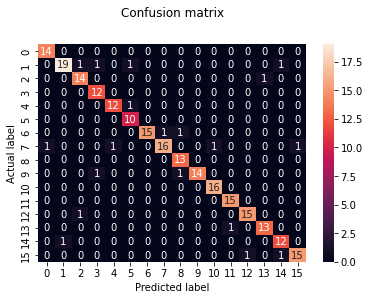

In [143]:
import seaborn as sns
sns.heatmap(confusion_matrix(t1, p1), annot=True)
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [151]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(t1, pred[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(t1, pred[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(t1))]
p_fpr, p_tpr, _ = roc_curve(t1, random_probs, pos_label=1)

In [153]:
print("AUC:",p_fpr, "\nROC:", p_tpr)

AUC: [0. 1.] 
ROC: [0. 1.]


In [131]:
import numpy as np
from keras.preprocessing import image
ImagePath='Face Images/Final Testing Images/face6/3face6.jpg'
#ImagePath=r'Face Images\Final Training Images\face8\image_0158_Face_1.jpg'
test_image=image.load_img(ImagePath,target_size=(64, 64))
test_image=image.img_to_array(test_image)

test_image1=np.expand_dims(test_image,axis=0)

result=classifier.predict(test_image1,verbose=0)
print(training_set.class_indices)
print('####'*10)
print('Prediction is: ',ResultMap[np.argmax(result)])

{'face1': 0, 'face10': 1, 'face11': 2, 'face12': 3, 'face13': 4, 'face14': 5, 'face15': 6, 'face16': 7, 'face2': 8, 'face3': 9, 'face4': 10, 'face5': 11, 'face6': 12, 'face7': 13, 'face8': 14, 'face9': 15}
########################################
Prediction is:  face6


In [39]:
result.shape

(1, 16)

In [132]:
test_image.shape

(64, 64, 3)